# Task1 - Segment the AO


In [40]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

images_path = "./Dataset/images/"
masks_path = "./Dataset/masks/"
image_name = "000002.png"

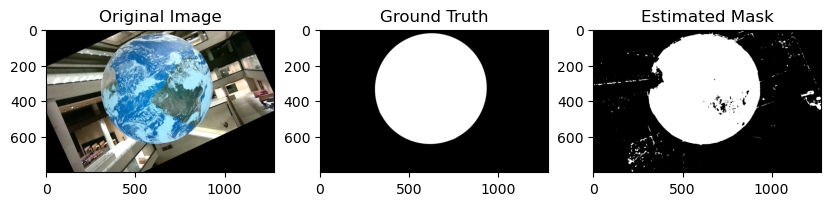

TPR: 0.95, FPR: 0.02


In [41]:
# Method1: Colort Thresholding
def color_thresh(img, hsv_low=(0, 0, 0), hsv_high=(255, 255, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, hsv_low, hsv_high)
    return mask

# Test
img = cv2.imread(os.path.join(images_path, image_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_gt = cv2.imread(os.path.join(masks_path, image_name), cv2.IMREAD_GRAYSCALE)
mask_est = color_thresh(img, (80, 10, 10), (180, 255, 255))
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(mask_gt, cmap="gray")
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(mask_est, cmap="gray")
plt.title("Estimated Mask")
plt.show()
# Caluculate TPR, FPR
TP = np.sum(np.logical_and(mask_gt, mask_est))
FP = np.sum(np.logical_and(mask_est, np.logical_not(mask_gt)))
TN = np.sum(np.logical_and(np.logical_not(mask_gt), np.logical_not(mask_est)))
FN = np.sum(np.logical_and(np.logical_not(mask_est), mask_gt))
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print("TPR: {:.2f}, FPR: {:.2f}".format(TPR, FPR))


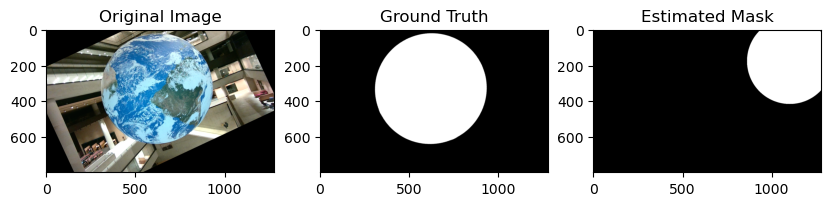

TPR: 0.02, FPR: 0.20


In [42]:
# Method2: Enclosing Circle with binary thresholding
def enclosing_circle_thresh(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 5000
    max_area = 0
    max_circle = None

    for contour in contours:
        area = cv2.contourArea(contour)
        box = cv2.minAreaRect(contour)
        if box[1][0] == 0 or box[1][1] == 0:
            continue
        roi = max(box[1][0] / box[1][1], box[1][1] / box[1][0])
        if roi > 1.5 or area < min_area:
            continue
        
        # 获取最小外接圆
        (x, y), radius = cv2.minEnclosingCircle(contour)
        if area > max_area:
            max_area = area
            max_circle = (x, y, radius)  # 更新最大外接圆

    # 如果找到了最大的外接圆，绘制它
    if max_circle:
        (x, y, radius) = max_circle
        center = (int(x), int(y))
        radius = int(radius - 10)

        # 创建掩码图像
        height, width = img.shape[:2]
        maskImg = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(maskImg, center, radius, 255, thickness=-1)
    else:
        # 如果没有符合条件的圆，返回空掩码
        height, width = img.shape[:2]
        maskImg = np.zeros((height, width), dtype=np.uint8)

    return maskImg

# Test
img = cv2.imread(os.path.join(images_path, image_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_gt = cv2.imread(os.path.join(masks_path, image_name), cv2.IMREAD_GRAYSCALE)
mask_est = enclosing_circle_thresh(img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(mask_gt, cmap="gray")
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(mask_est, cmap="gray")
plt.title("Estimated Mask")
plt.show()
# Caluculate TPR, FPR
TP = np.sum(np.logical_and(mask_gt, mask_est))
FP = np.sum(np.logical_and(mask_est, np.logical_not(mask_gt)))
TN = np.sum(np.logical_and(np.logical_not(mask_gt), np.logical_not(mask_est)))
FN = np.sum(np.logical_and(np.logical_not(mask_est), mask_gt))
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print("TPR: {:.2f}, FPR: {:.2f}".format(TPR, FPR))

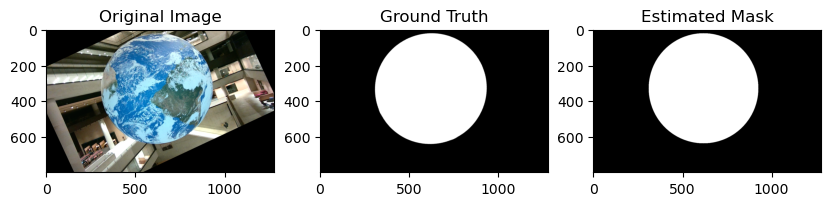

TPR: 0.97, FPR: 0.00


In [43]:
def get_mask(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Method1: Color Thresholding
    lower_hsv = np.array([80, 10, 10])
    upper_hsv = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # Noise removal
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=2) 
    mask = cv2.dilate(mask, kernel, iterations=2)
    
    # Method2: Enclosing Circle
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 5000
    max_area = 0
    max_circle = None

    for contour in contours:
        area = cv2.contourArea(contour)
        box = cv2.minAreaRect(contour)
        if box[1][0] == 0 or box[1][1] == 0:
            continue
        roi = max(box[1][0] / box[1][1], box[1][1] / box[1][0])
        if roi > 1.5 or area < min_area:
            continue
        # Find minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        if area > max_area:
            max_area = area
            max_circle = (x, y, radius)

    if max_circle:
        (x, y, radius) = max_circle
        center = (int(x), int(y))
        radius = int(radius - 10)

        # Create mask
        height, width = image.shape[:2]
        maskImg = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(maskImg, center, radius, 255, thickness=-1)
    else:
        # Return empty mask
        height, width = image.shape[:2]
        maskImg = np.zeros((height, width), dtype=np.uint8)

    return maskImg

# Test
img = cv2.imread(os.path.join(images_path, image_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_gt = cv2.imread(os.path.join(masks_path, image_name), cv2.IMREAD_GRAYSCALE)
mask_est = get_mask(img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(mask_gt, cmap="gray")
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(mask_est, cmap="gray")
plt.title("Estimated Mask")
plt.show()
# Caluculate TPR, FPR
TP = np.sum(np.logical_and(mask_gt, mask_est))
FP = np.sum(np.logical_and(mask_est, np.logical_not(mask_gt)))
TN = np.sum(np.logical_and(np.logical_not(mask_gt), np.logical_not(mask_est)))
FN = np.sum(np.logical_and(np.logical_not(mask_est), mask_gt))
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print("TPR: {:.2f}, FPR: {:.2f}".format(TPR, FPR))

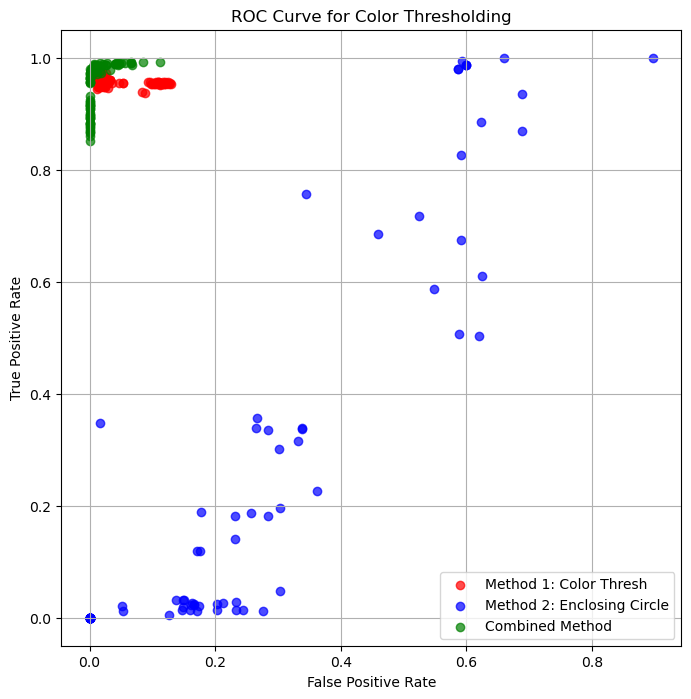

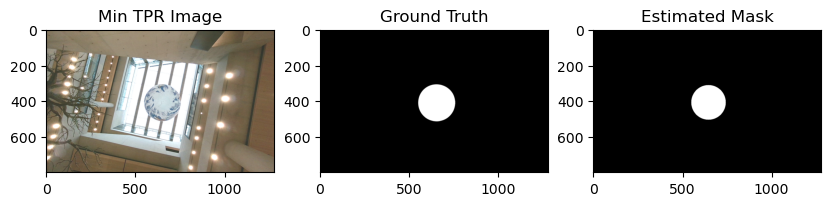

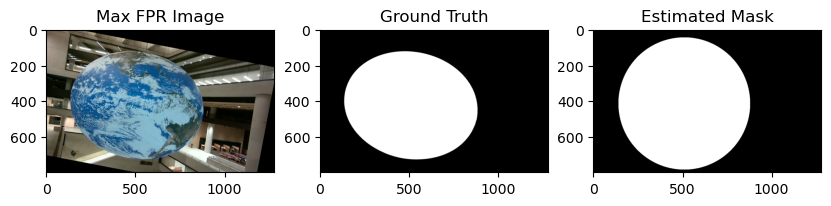

In [ ]:
# Evaluation
# Read all images
images = os.listdir(images_path)
masks = os.listdir(masks_path)

# Create list for data
FPR_m1_list = []
TPR_m1_list = []
FPR_m2_list = []
TPR_m2_list = []
FPR_combined_list = []
TPR_combined_list = []

min_TPR = 1
max_FPR = 0
worst_img1 = None
worst_img2 = None
worst_mask1 = None
worst_mask2 = None
worst_est_mask1 = None
worst_est_mask2 = None

# Evaluation 
for i in range(len(images)):
    img = cv2.imread(os.path.join(images_path, images[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask_gt = cv2.imread(os.path.join(masks_path, masks[i]), cv2.IMREAD_GRAYSCALE)
    mask_est_m1 = color_thresh(img,(80, 10, 10), (180, 255, 255))
    mask_est_m2 = enclosing_circle_thresh(img)
    mask_est = get_mask(img)

    # Calculate TPR, FPR
    TP_m1 = np.sum(np.logical_and(mask_gt, mask_est_m1))
    FP_m1 = np.sum(np.logical_and(mask_est_m1, np.logical_not(mask_gt)))
    TN_m1 = np.sum(np.logical_and(np.logical_not(mask_gt), np.logical_not(mask_est_m1)))
    FN_m1 = np.sum(np.logical_and(np.logical_not(mask_est_m1), mask_gt))
    TPR_m1 = TP_m1 / (TP_m1 + FN_m1)
    FPR_m1 = FP_m1 / (FP_m1 + TN_m1)

    TP_m2 = np.sum(np.logical_and(mask_gt, mask_est_m2))
    FP_m2 = np.sum(np.logical_and(mask_est_m2, np.logical_not(mask_gt)))
    TN_m2 = np.sum(np.logical_and(np.logical_not(mask_gt), np.logical_not(mask_est_m2)))
    FN_m2 = np.sum(np.logical_and(np.logical_not(mask_est_m2), mask_gt))
    TPR_m2 = TP_m2 / (TP_m2 + FN_m2)
    FPR_m2 = FP_m2 / (FP_m2 + TN_m2)

    TP = np.sum(np.logical_and(mask_gt, mask_est))
    FP = np.sum(np.logical_and(mask_est, np.logical_not(mask_gt)))
    TN = np.sum(np.logical_and(np.logical_not(mask_gt), np.logical_not(mask_est)))
    FN = np.sum(np.logical_and(np.logical_not(mask_est), mask_gt))
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    if TPR < min_TPR:
        min_TPR = TPR
        worst_img1 = img
        worst_mask1 = mask_gt
        worst_est_mask1 = mask_est
    if FPR > max_FPR:
        max_FPR = FPR
        worst_img2 = img
        worst_mask2 = mask_gt
        worst_est_mask2 = mask_est

    FPR_m1_list.append(FPR_m1)
    TPR_m1_list.append(TPR_m1)
    FPR_m2_list.append(FPR_m2)
    TPR_m2_list.append(TPR_m2)
    FPR_combined_list.append(FPR)
    TPR_combined_list.append(TPR)

# Plot all points on the same ROC curve
plt.figure(figsize=(8, 8))
plt.scatter(FPR_m1_list, TPR_m1_list, c="red", label="Method 1: Color Thresh", alpha=0.7)
plt.scatter(FPR_m2_list, TPR_m2_list, c="blue", label="Method 2: Enclosing Circle", alpha=0.7)
plt.scatter(FPR_combined_list, TPR_combined_list, c="green", label="Combined Method", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Combined Method")
plt.legend()
plt.grid()
plt.show()

# Limitation Analysis
# Plot worst image, gt mask and estimated mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(worst_img1)
plt.title("Min TPR Image")
plt.subplot(1, 3, 2)
plt.imshow(worst_mask1, cmap="gray")
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(worst_est_mask1, cmap="gray")
plt.title("Estimated Mask")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(worst_img2)
plt.title("Max FPR Image")
plt.subplot(1, 3, 2)
plt.imshow(worst_mask2, cmap="gray")
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(worst_est_mask2, cmap="gray")
plt.title("Estimated Mask")
plt.show()



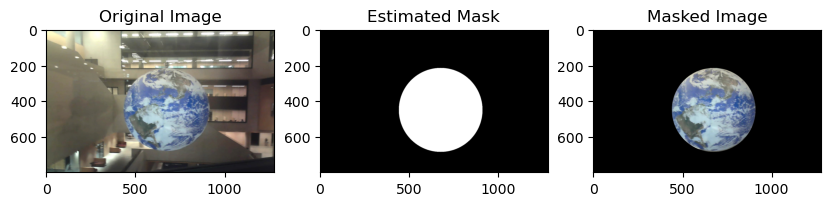

In [45]:
# Test on our own image
img = cv2.imread("./Dataset/grp6/task1/our_AO_cap.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_est = get_mask(img)
masked_img = cv2.bitwise_and(img, img, mask=mask_est)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(mask_est, cmap="gray")
plt.title("Estimated Mask")
plt.subplot(1, 3, 3)
plt.imshow(masked_img)
plt.title("Masked Image")
plt.show()
